In [233]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (17, 7)
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
dtype = np.float32

In [234]:
def bvp(kind: int, x_0: float, y_0: float, x_n: float, y_n: float, F: function, G: function):
    x = Symbol('x')
    y = Function('y')(x)
    F, G = F(x), G(x)
    ode = Eq(
        y.diff(x, 2) + F * y,
        G,
    )
    dy = y.diff(x, kind - 1)
    ics = {
        dy.subs(x, x_0): y_0,
        dy.subs(x, x_n): y_n,
    }
    Y = dsolve(ode, y, ics=ics).rhs.evalf()
    return {'x': x, 'y': y}, {'Y': Y, 'F': F, 'G': G}

In [274]:
xlim = {'x_0': 0, 'x_n': 15}
conditions = {
    'kind': 2,
    'y_0': 1, 'y_n': 2,
    'F': lambda x: (10 / (1 + x)),
    'G': lambda x: 0 * x,
}
conditions.update(xlim)
variables, functions = bvp(**conditions)
# functions['Y'].subs(variables['x'], 2).evalf()

In [275]:
def to_arrays(xlim: dict, x: Symbol, y: Function, Y: Function, F: Function, G: Function):
    x_0, x_n = xlim['x_0'], xlim['x_n']
    n = (x_n - x_0) * 30
    aX = np.linspace(x_0, x_n, n, dtype=dtype)
    aY = np.array([Y.subs(x, i).evalf() for i in aX], dtype=dtype)
    aF = np.array([F.subs(x, i).evalf() for i in aX], dtype=dtype)
    aG = np.array([G.subs(x, i).evalf() for i in aX], dtype=dtype)
    arrays = {'Y(x)': np.array([aX, aY]), 'F(x)': np.array([aX, aF]), 'G(x)': np.array([aX, aG])}
    return arrays

In [276]:
def plot(xlim: dict, arrays: dict):
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([xlim['x_0'], xlim['x_n']])
    for label, value in arrays.items():
        plt.plot(*value, label=label)
    plt.legend()
    plt.grid()
    plt.show()

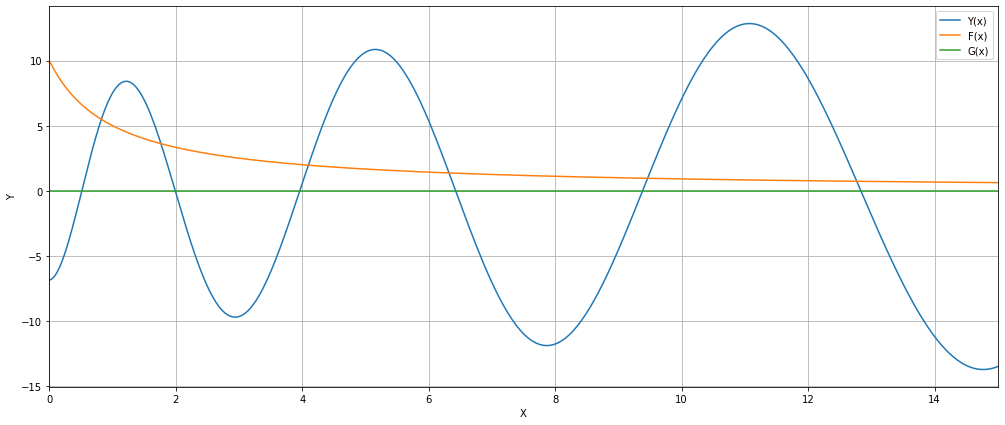

In [277]:
arrays = to_arrays(xlim, **variables, **functions)
plot(xlim, arrays)

In [305]:
import torch
sample = arrays['Y(x)'].T
x_train = torch.tensor(sample[::2])
x_train += torch.randn(x_train.shape) / 5 # noise
y_train = torch.tensor(arrays['F(x)'][1, ::2]).unsqueeze(1)

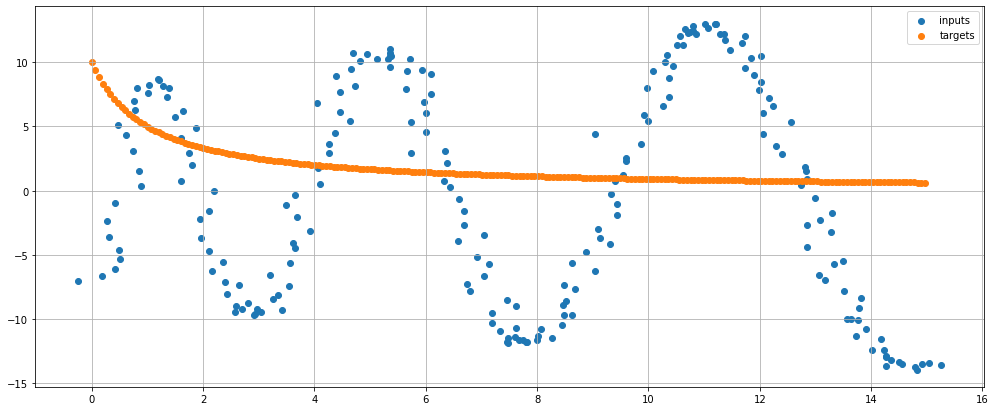

In [306]:
plt.scatter(*x_train.T, label='inputs')
plt.scatter(sample[::2, 0], y_train, label='targets')
plt.legend()
plt.grid()
plt.show()

In [307]:
x_valid = torch.tensor(sample[1::2])
y_valid = torch.tensor(arrays['F(x)'][1, 1::2]).unsqueeze(1)

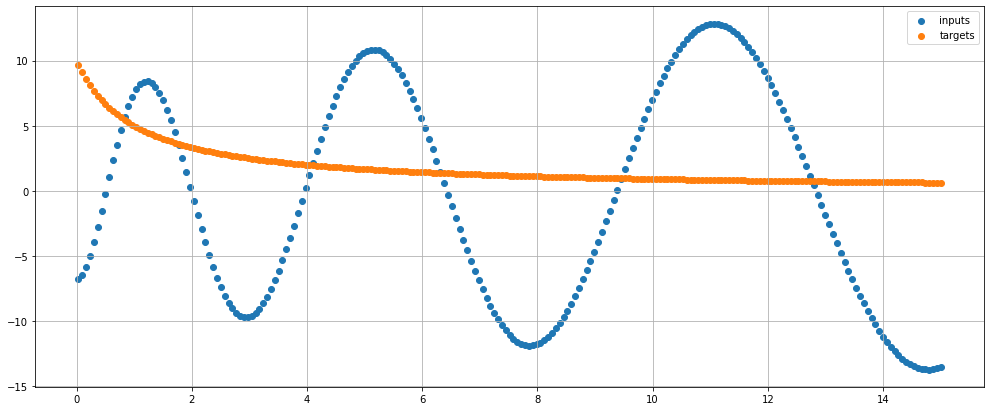

In [308]:
plt.scatter(*x_valid.T, label='inputs')
plt.scatter(sample[1::2, 0], y_valid, label='targets')
plt.legend()
plt.grid()
plt.show()

In [309]:
import torch.nn.functional as F

class BvpNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons = 4):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

model = BvpNet()

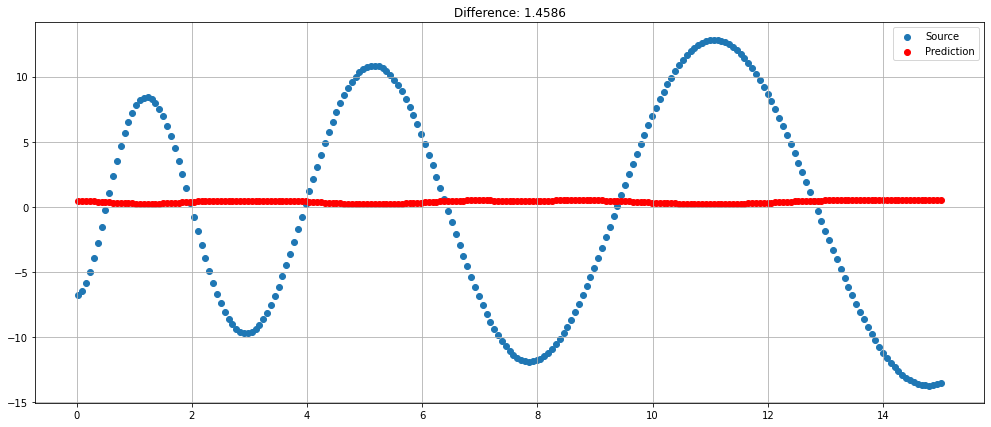

In [310]:
def predict(model, x, y):
    y_pred = model(x).detach()
    difference = round(float((y - y_pred).abs().mean().numpy()), 4)
    plt.title(f'Difference: {difference}')
    plt.scatter(*x.T, label='Source')
    plt.scatter(x[:, 0], y_pred, c='r', label='Prediction')
    plt.legend()
    plt.grid()
    plt.show()

predict(model, x_valid, y_valid)

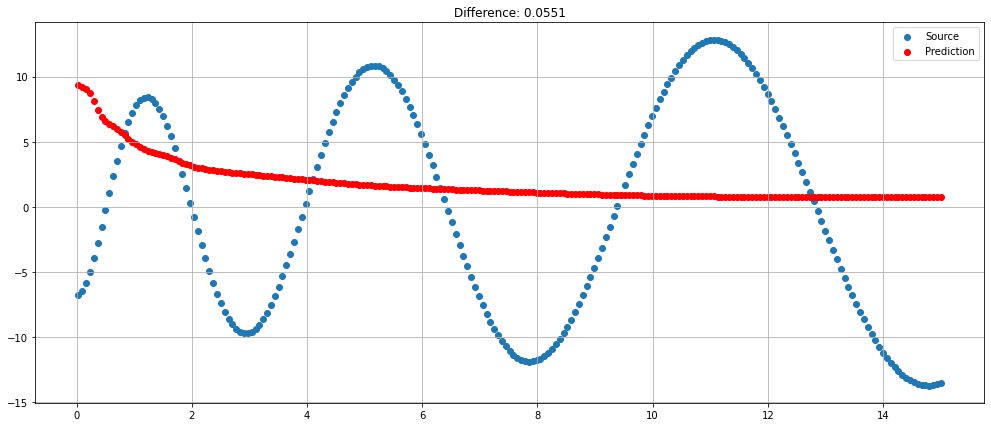

In [311]:
model = BvpNet()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch_index in range(2000):
    y_pred = model(x_train)

    loss_val = loss(y_pred, y_train)
    loss_val.backward()

    optimizer.step()
    optimizer.zero_grad()

model.eval()
predict(model, x_valid, y_valid)